# Electricity Price Prediction Pipeline (Finland): Cleaning and Feature Engineering

## Project Objective
The goal of this notebook is to clean, aggregate, and transform energy market data to train a machine learning model capable of predicting two days-ahead electricity prices (EUR/MWh) in Finland. 

## Data Sources
The dataset aggregates data from three primary sources (2023–Present):
*   **Fingrid (TSO):** Real-time nuclear production, wind power forecasts, solar forecasts, and total consumption forecasts.
*   **FMI (Finnish Meteorological Institute):** Historical weather observations (Temperature, Wind Speed) for key demand/production centers (Helsinki, Pori).
*   **Entso-E:** Historical Day-Ahead Spot Prices for the FI bidding zone.

## Methodology
1.  **Data Ingestion & Timezone Standardization:** All data is converted to `Europe/Helsinki` time to ensure alignment with local market hours.
2.  **Missing Value Imputation:** Linear interpolation is used for short gaps; longer gaps are handled via forward filling.
3.  **Feature Engineering:** 
    *   Creation of extra features like "residual demand"
    *   Lagged nuclear production feature to mimic information available at inference time (preventing data leakage). However, due to data availability, weather data used is real-time data, not forecast.


## Methodology
1.  **Data Ingestion & Timezone Standardization:** All data is converted to `Europe/Helsinki` time and resampled to an hourly frequency to ensure alignment with local market hours.
2.  **Missing Value Imputation:** Short data gaps (e.g., up to 4 hours) are filled using linear interpolation; longer gaps are handled via forward filling.
3.  **Feature Engineering & Data Leakage Compromises:**
    *   **Core Feature Creation:** Extra features such as "residual demand" (Consumption Forecast - Cheap Supply) and Supply/Demand Ratios are calculated.
    *   **Time Features:** Cyclical features (Hour, Day of Week, Month) are extracted from the timestamp index.
    *   **Nuclear Data Handling:** Since a dedicated nuclear power forecast was unavailable, the actual nuclear production feature was shifted by 72 hours (`price_lag_72`) to create a proxy feature that is known at the time of the 48-hour prediction, thereby preventing data leakage at the point of inference.
    *   **Weather Data Compromise:** Due to the unavailability of historical weather forecastdata from FMI for the training period, the model was trained using real-time weather observations (Temperature, Wind Speed).

# Data cleaning

In [1]:
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Target timezone
TZ = 'Europe/Helsinki'

In [2]:
# Setup to show all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_seq_items', 2000)

In [3]:
df = pd.read_csv("../data/fingrid_nuclear.csv", sep=';')
df.head(1)

,startTime,endTime,Nuclear power production - real-time data
0,2022-12-31T22:01:00.000Z,2022-12-31T22:01:00.000Z,4374.8


In [4]:
def process_fingrid_file(filepath, col_name):
    df = pd.read_csv(filepath, sep=";")

    # Clean time
    df['timestamp'] = pd.to_datetime(df['startTime'])
    df = df.set_index('timestamp').tz_convert(TZ)

    # Resample to hourly mean and rename third colume
    third_col_name = df.columns[2]
    df_hourly = df[[third_col_name]].resample('1h').mean().rename(columns={third_col_name: col_name})

    return df_hourly

# Load files
df_nuke = process_fingrid_file("../data/fingrid_nuclear.csv", "nuclear_mw")
df_wind = process_fingrid_file("../data/fingrid_wind.csv", "wind_forecast_72h_mw")
df_solar = process_fingrid_file("../data/fingrid_solar.csv", "solar_forecast_72h_mw")
df_cons = process_fingrid_file("../data/fingrid_consump.csv", "consumption_forecast_72h_mw")
df_prod = process_fingrid_file("../data/fingrid_elect_production.csv", "total_production_forecast_mw")

In [5]:
print(df_nuke.head(2))
print(df_nuke.shape)
print(df_wind.head(2))
print(df_wind.shape)
print(df_cons.head(2))
print(df_cons.shape)
print(df_solar.tail(2))
print(df_solar.shape)


                            nuclear_mw
timestamp                             
2023-01-01 00:00:00+02:00  4370.664997
2023-01-01 01:00:00+02:00  4371.914998
(25536, 1)
                           wind_forecast_72h_mw
timestamp                                      
2023-01-01 00:00:00+02:00            3663.00000
2023-01-01 01:00:00+02:00            3720.59999
(25536, 1)
                           consumption_forecast_72h_mw
timestamp                                             
2023-01-01 00:00:00+02:00                   9291.29999
2023-01-01 01:00:00+02:00                   9005.20000
(25536, 1)
                           solar_forecast_72h_mw
timestamp                                       
2025-11-29 22:00:00+02:00                    0.0
2025-11-29 23:00:00+02:00                    0.0
(25536, 1)


In [6]:
def clean_fmi_data(filepath, location_name):
    df = pd.read_csv(filepath)
    
    # Create a single Datetime column from Year, Month, Day, Time (format: "2023-01-01 04:00")
    df['timestamp'] = pd.to_datetime(
        df[['Year', 'Month', 'Day']].astype(str).agg('-'.join, axis=1) + ' ' + df['Time [UTC]']
    )
    
    # Handle Timezones, by localizing to UTC then convert to Helsinki
    df = df.set_index('timestamp').tz_localize('UTC').tz_convert(TZ)
    
    # Rename columns to be specific (e.g., temp_helsinki)
    df = df[['Wind speed [m/s]', 'Average temperature [°C]']].copy()
    df.columns = [f'wind_{location_name}', f'temp_{location_name}']
    return df


df_helsinki = clean_fmi_data("../data/helsinki_weather.csv", "helsinki")
df_pori = clean_fmi_data("../data/pori_weather.csv", "pori")

print("Shape helsinki:", df_helsinki.shape)
print("Shape pori:", df_pori.shape)
print(df_helsinki.head(2))

Shape helsinki: (25560, 2)
Shape pori: (25508, 2)
                          wind_helsinki temp_helsinki
timestamp                                            
2023-01-01 02:00:00+02:00           5.4             5
2023-01-01 03:00:00+02:00           4.9           4.5


In [ ]:
def load_prices(folder_path):
    # Get all CSV files in the folder
    all_files = glob.glob(os.path.join(folder_path, "*.csv"))

    df_list = []

    for filename in all_files:
        df = pd.read_csv(filename, sep='\t')

        # Filter Finland
        df = df[df['MapCode'] == 'FI']

        df_list.append(df)

    # Combine all months into one df
    full_df = pd.concat(df_list, axis=0, ignore_index=True)
    
    # Convert datetime column to timestamp
    full_df['timestamp'] = pd.to_datetime(full_df['DateTime(UTC)'])

    # Handle timezone
    full_df  = full_df.set_index('timestamp').tz_localize('UTC').tz_convert(TZ)

    # Keep only price column
    full_df = full_df[['Price[Currency/MWh]']].rename(columns={'Price[Currency/MWh]': 'price'})

    # Sort by time
    full_df = full_df.sort_index()

    # Handle 15-min data (sept 2025 onwards in prices) 
    full_df = full_df.resample('1h').mean()

    # Handle duplicates
    full_df = full_df[~full_df.index.duplicated(keep='first')]

    return full_df

# Clean price data
df_prices = load_prices("../data/raw_prices/")
print("df_prices shape: ", df_prices.shape)
print(df_prices.tail(2))


df_prices shape:  (25560, 1)
                             price
timestamp                         
2025-12-01 00:00:00+02:00  20.7725
2025-12-01 01:00:00+02:00  18.5200


In [8]:
## Combine dataframes
# Join Helsinki and Pori
df_weather = df_helsinki.join(df_pori, how='inner')

# Join Weather, Prices, nuke, wind, consump, and prod
df_comb = df_prices.join(df_weather, how='inner')
df_comb = df_comb.join(df_nuke, how='left')
df_comb = df_comb.join(df_wind, how='left')
df_comb = df_comb.join(df_cons, how='left')
df_comb = df_comb.join(df_solar, how='left')

print("df helsinki shape: ", df_helsinki.shape)
print("df pori shape: ", df_pori.shape)
print("df weather shape: ", df_weather.shape)
print("df prices shape: ", df_prices.shape)
print("df nuke shape", df_nuke.shape)
print("df solar shape", df_solar.shape)
print("fd_comb shape: ", df_comb.shape)
print(df_comb.head(2))

df helsinki shape:  (25560, 2)
df pori shape:  (25508, 2)
df weather shape:  (25508, 4)
df prices shape:  (25560, 1)
df nuke shape (25536, 1)
df solar shape (25536, 1)
fd_comb shape:  (25508, 9)
                           price wind_helsinki temp_helsinki wind_pori temp_pori   nuclear_mw  wind_forecast_72h_mw  consumption_forecast_72h_mw  solar_forecast_72h_mw
timestamp                                                                                                                                                              
2023-01-01 02:00:00+02:00   1.38           5.4             5      10.7       2.9  4371.744998            3711.19999                   8769.79999                    0.0
2023-01-01 03:00:00+02:00   0.09           4.9           4.5      10.9       2.9  4373.079996            3694.50000                   8649.20000                    0.0


In [10]:
## Fill missing values

# Convert to numeric
for col in df_comb.columns:
    df_comb[col] = pd.to_numeric(df_comb[col], errors='coerce')

# Fill missing values (interpolation)
df_comb_fill = df_comb.interpolate(method='linear')

# Backward fill in case of missing values at the start/end
df_comb_fill = df_comb_fill.bfill().ffill()


# Create a missing summary dataframe
missing_summary = pd.DataFrame({
    'Missing count': df_comb.isnull().sum(),
    'Percentage (%)': (df_comb.isnull().mean() * 100).round(2)
})
print("Missing Data Summary (Before Fill):")
print(missing_summary.sort_values(by='Missing count', ascending=False))

print("\nNan count after fill: \n", df_comb_fill.isnull().sum())

Missing Data Summary (Before Fill):
                             Missing count  Percentage (%)
wind_helsinki                          204            0.80
nuclear_mw                              74            0.29
solar_forecast_72h_mw                   26            0.10
wind_forecast_72h_mw                    26            0.10
consumption_forecast_72h_mw             26            0.10
temp_helsinki                           17            0.07
wind_pori                               11            0.04
temp_pori                                1            0.00
price                                    0            0.00

Nan count after fill: 
 price                          0
wind_helsinki                  0
temp_helsinki                  0
wind_pori                      0
temp_pori                      0
nuclear_mw                     0
wind_forecast_72h_mw           0
consumption_forecast_72h_mw    0
solar_forecast_72h_mw          0
dtype: int64


In [11]:
df_comb_fill.to_csv("../data/processed_data.csv")

# Feature engineering

In [12]:
if 'df_comb_fill' not in locals():
    df = pd.read_csv("../data/processed_data.csv", index_col=0, parse_dates=True)

    df.index = pd.to_datetime(df.index, utc=True)

    TZ = 'Europe/Helsinki'
    df = df.tz_convert(TZ)
else:
    df = df_comb_fill.copy()
print(df.head(1))

                           price  wind_helsinki  temp_helsinki  wind_pori  temp_pori   nuclear_mw  wind_forecast_72h_mw  consumption_forecast_72h_mw  solar_forecast_72h_mw
timestamp                                                                                                                                                                  
2023-01-01 02:00:00+02:00   1.38            5.4            5.0       10.7        2.9  4371.744998            3711.19999                   8769.79999                    0.0


In [13]:
# Feature engineering

# Time features
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Price lags
# Yesterday price
df['price_lag_24'] = df['price'].shift(24)
# Last week price
df['price_lag_168'] = df['price'].shift(168)
# Nuclear power 3 days ago
df['nuclear_mw'] = df['nuclear_mw'].shift(72)

# Domain features

# Total cheap supply (nuclear + wind + solar)
df['total_cheap_supply'] = df['nuclear_mw'] + df['wind_forecast_72h_mw'] + df['solar_forecast_72h_mw']

# Residual demand (consumption forecast - cheap supply)
df['residual_demand'] = df['consumption_forecast_72h_mw'] - df['total_cheap_supply']

# Supply/demand ratio, (if ratio > 1 = cheap supply, if ratio < 1 = expensive supply)
df['supply_demand_ratio'] = df['total_cheap_supply'] / (df['consumption_forecast_72h_mw'] + 1)


# Rolling forecasts
df['wind_forecast_roll_6h'] = df['wind_forecast_72h_mw'].rolling(window=6).mean()
df['consumption_forecast_roll_6h'] = df['consumption_forecast_72h_mw'].rolling(window=6).mean()

# Drop empty rows from beginning caused by shift
print("df shape before drop: ", df.shape)
df = df.dropna()
print("df shape after drop: ", df.shape)

print(df.head(2))

df shape before drop:  (25508, 20)
df shape after drop:  (25340, 20)
                           price  wind_helsinki  temp_helsinki  wind_pori  temp_pori   nuclear_mw  wind_forecast_72h_mw  consumption_forecast_72h_mw  solar_forecast_72h_mw  hour  day_of_week  month  is_weekend  price_lag_24  price_lag_168  total_cheap_supply  residual_demand  supply_demand_ratio  wind_forecast_roll_6h  consumption_forecast_roll_6h
timestamp                                                                                                                                                                                                                                                                                                                                                    
2023-01-08 02:00:00+02:00    9.3            5.0           -7.6       12.3       -5.0  3674.574998                3554.4                  10447.79999                    0.0     2            6      1           1         69.93        

In [14]:
df.to_csv("../data/processed_feature_data.csv")

# Exploratory data analysis

In [15]:
print(df.describe())

              price  wind_helsinki  temp_helsinki     wind_pori     temp_pori    nuclear_mw  wind_forecast_72h_mw  consumption_forecast_72h_mw  solar_forecast_72h_mw          hour   day_of_week         month    is_weekend  price_lag_24  price_lag_168  total_cheap_supply  residual_demand  supply_demand_ratio  wind_forecast_roll_6h  consumption_forecast_roll_6h
count  25340.000000   25340.000000   25340.000000  25340.000000  25340.000000  25340.000000          25340.000000                 25340.000000           25340.000000  25340.000000  25340.000000  25340.000000  25340.000000  25340.000000   25340.000000        25340.000000     25340.000000         25340.000000           25340.000000                  25340.000000
mean      47.350839       3.832999       7.950860      6.499838      7.043852   3596.436323           2140.699857                  9258.814330             132.248405     11.497001      3.003354      6.397238      0.286859     47.395272      47.720101         5869.384586      

price                           1.000000
residual_demand                 0.579134
price_lag_24                    0.408844
consumption_forecast_72h_mw     0.298753
consumption_forecast_roll_6h    0.272051
price_lag_168                   0.172704
hour                            0.129022
nuclear_mw                     -0.019303
solar_forecast_72h_mw          -0.073896
month                          -0.084707
wind_helsinki                  -0.134864
day_of_week                    -0.135133
is_weekend                     -0.163422
temp_helsinki                  -0.295173
temp_pori                      -0.307361
wind_pori                      -0.323911
wind_forecast_roll_6h          -0.353220
total_cheap_supply             -0.359162
wind_forecast_72h_mw           -0.365885
supply_demand_ratio            -0.533673
Name: price, dtype: float64


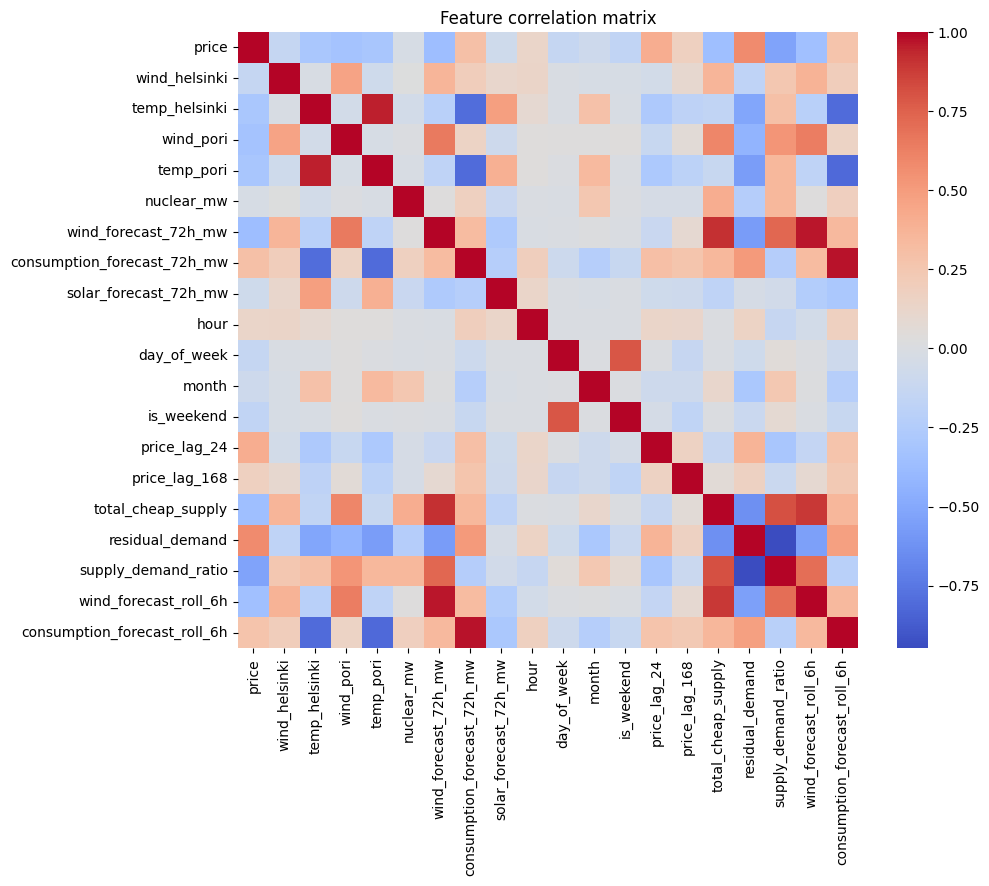

In [16]:
# Price correlation with features
corr = df.corr()['price'].sort_values(ascending=False)

print(corr)

plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
plt.title("Feature correlation matrix")
plt.show()

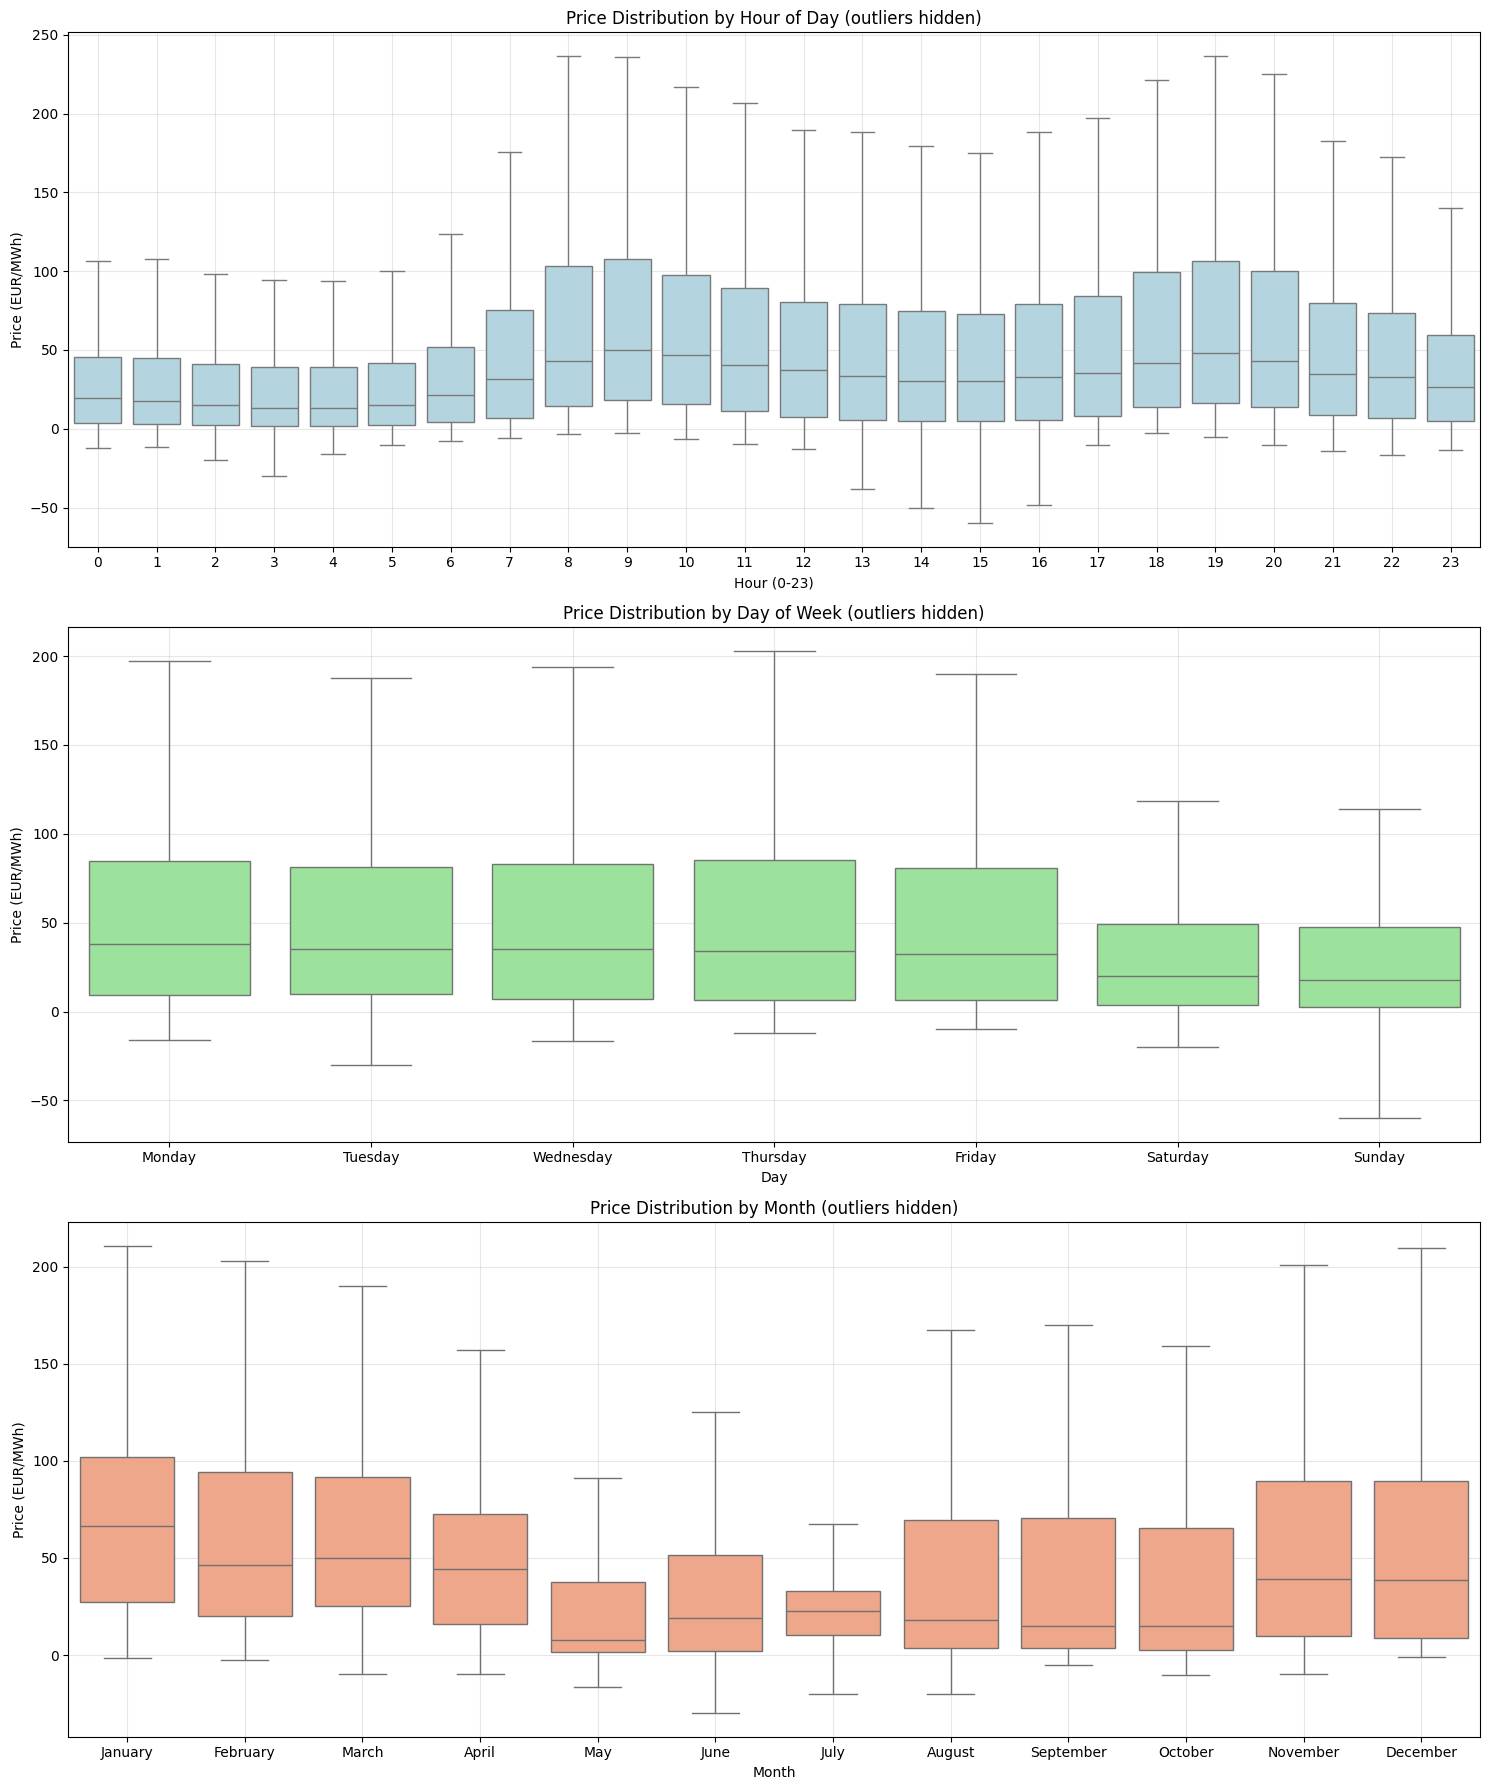

In [17]:
# Visualize price cycles

# Create temporary features for plotting
plot_df = df_comb_fill.copy()
plot_df['hour'] = plot_df.index.hour
plot_df['day_name'] = plot_df.index.day_name()
plot_df['month_name'] = plot_df.index.month_name()

# Define sorting orders
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                'July', 'August', 'September', 'October', 'November', 'December']

fig, axes = plt.subplots(3, 1, figsize=(15, 18))

# Plot 1: Price distribution by Hour of Day
sns.boxplot(data=plot_df, x='hour', y='price', ax=axes[0], showfliers=False, color='lightblue')
axes[0].set_title("Price Distribution by Hour of Day (outliers hidden)")
axes[0].set_xlabel("Hour (0-23)")
axes[0].set_ylabel("Price (EUR/MWh)")
axes[0].grid(True, alpha=0.3)

# Plot 2: Price distribution by Day of Week
sns.boxplot(data=plot_df, x='day_name', y='price', ax=axes[1], order=days_order, showfliers=False, color='lightgreen')
axes[1].set_title("Price Distribution by Day of Week (outliers hidden)")
axes[1].set_xlabel("Day")
axes[1].set_ylabel("Price (EUR/MWh)")
axes[1].grid(True, alpha=0.3)

# Plot 3: Price distribution by Month
sns.boxplot(data=plot_df, x='month_name', y='price', ax=axes[2], order=months_order, showfliers=False, color='lightsalmon')
axes[2].set_title("Price Distribution by Month (outliers hidden)")
axes[2].set_xlabel("Month")
axes[2].set_ylabel("Price (EUR/MWh)")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

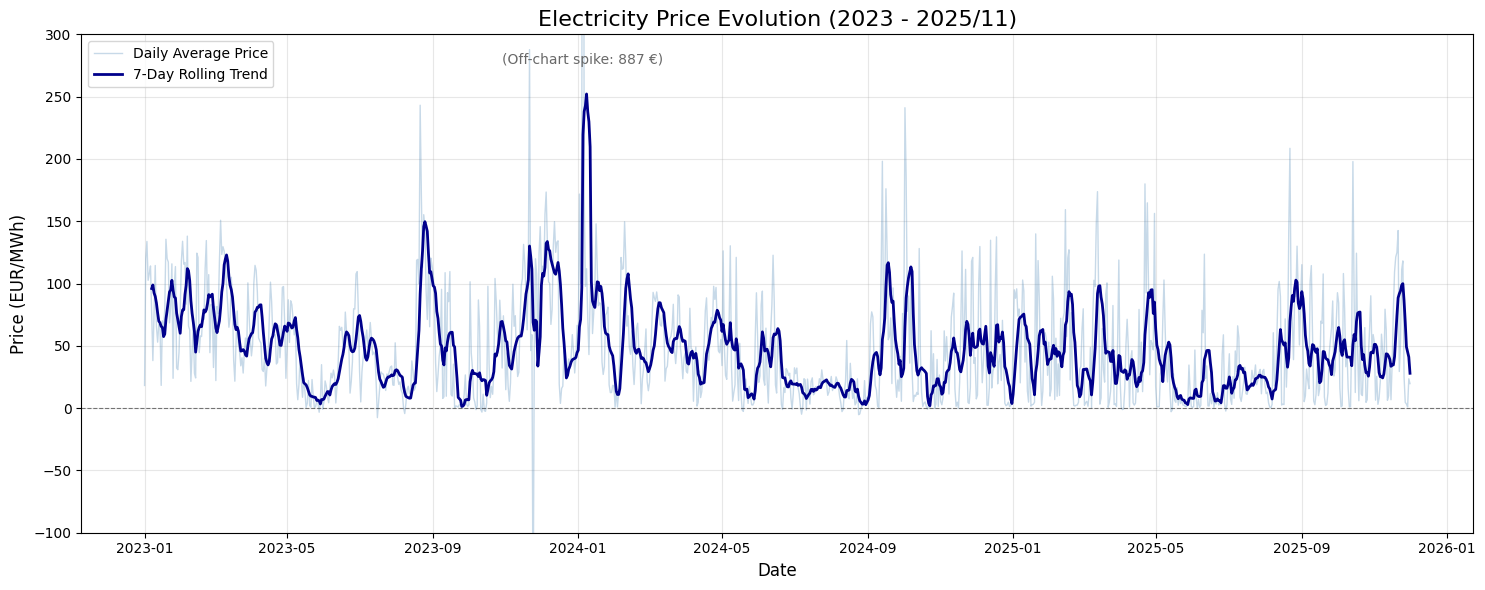

In [ ]:
# Visualize Price Evolution Over Time 

plt.figure(figsize=(15, 6))

# Resample to Daily Mean
daily_price = df_comb_fill['price'].resample('D').mean()
# Calculate 7-day Rolling Mean
rolling_price = daily_price.rolling(window=7).mean()

# Plot
plt.plot(daily_price.index, daily_price, label='Daily Average Price', color='steelblue', alpha=0.3, linewidth=1)
plt.plot(rolling_price.index, rolling_price, label='7-Day Rolling Trend', color='darkblue', linewidth=2)

# Outlier handling
max_price = daily_price.max()
max_date = daily_price.idxmax()

# Set Y-axis limits to focus on the "normal" data
upper_limit = 300 
plt.ylim(bottom=-100, top=upper_limit)

# Add text label at the top of the chart near the spike date
plt.text(max_date, upper_limit - 15, 
         f'(Off-chart spike: {max_price:.0f} €)', 
         ha='center', va='top', 
         color='dimgray', fontsize=10)

plt.title("Electricity Price Evolution (2023 - 2025/11)", fontsize=16)
plt.ylabel("Price (EUR/MWh)", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

plt.axhline(0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)

plt.tight_layout()
plt.show()